In [15]:
import pandas as pd

df = pd.read_csv('../data/titanic_passengers.csv')

df.info()
#get rid of missing information
df = df.dropna()

df.info()
#ignore passenger id - not needed
df = df.drop(columns=['PassengerId', "Name", "Ticket", "Cabin"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     

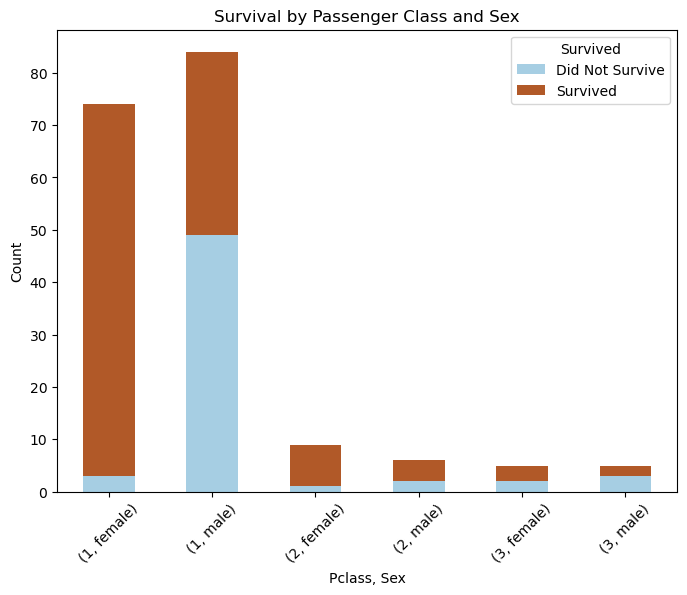

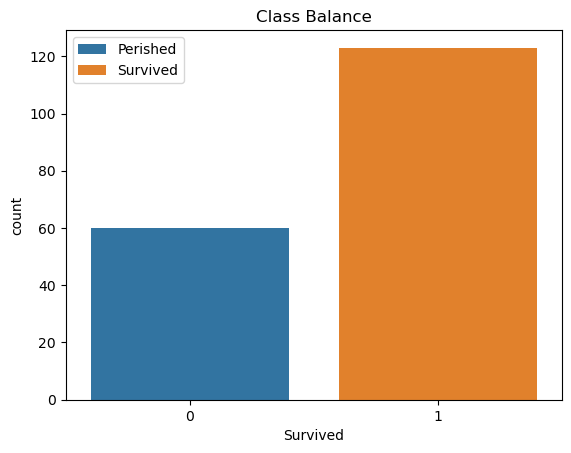

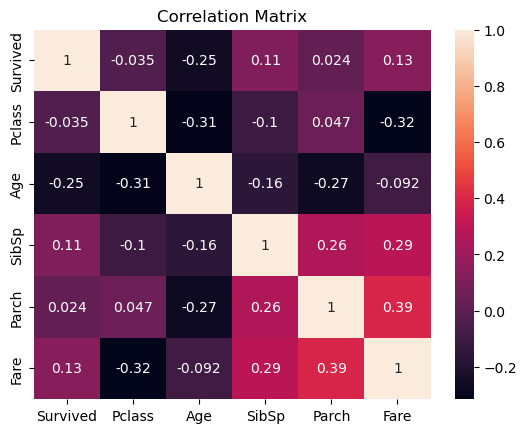

In [16]:
# -- EDA
import matplotlib.pyplot as plt
import seaborn as sns

grouped = df.groupby(["Pclass", "Sex"])["Survived"].value_counts().unstack().fillna(0)

# Plot stacked bar
grouped.plot(kind="bar", stacked=True, figsize=(8,6), colormap="Paired")

plt.title("Survival by Passenger Class and Sex")
plt.xlabel("Pclass, Sex")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["Did Not Survive", "Survived"])
plt.xticks(rotation=45)
plt.show()

#Class Balance
sns.countplot(x='Survived', data=df, hue='Survived')
plt.title('Class Balance')
plt.legend(['Perished', 'Survived'])
plt.show()

#Correlation Matrix
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [17]:
# -- Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

#Encode categorical features
df = pd.get_dummies(df, columns=["Sex", "Embarked", "Pclass"], drop_first=True)

#Seperate Features
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

#KNN
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Prediction example (dummy passenger features)
sample = [[22, 1, 0, 7.25,   # Age, SibSp, Parch, Fare
           1,                # Sex_male (1=male, 0=female)
           0, 1, 0,          # Embarked (C, Q), one-hot
           1]]            # Pclass dummies (Pclass_2, Pclass_3)
prediction = model.predict(sample)
print("Prediction:", "Survived" if prediction[0]==1 else "Did Not Survive")

# Score
test_score = model.score(X_test, y_test)
print(f"Test score: {test_score:.2f}")

# Classification report
print(classification_report(y_test, model.predict(X_test)))


Prediction: Survived
Test score: 0.59
              precision    recall  f1-score   support

           0       0.29      0.17      0.21        12
           1       0.67      0.80      0.73        25

    accuracy                           0.59        37
   macro avg       0.48      0.48      0.47        37
weighted avg       0.54      0.59      0.56        37



c:\Users\rhbyr\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


      Feature    F-Score
4    Sex_male  71.605923
0         Age  12.491639
3        Fare   3.321597
1       SibSp   2.070439
6  Embarked_S   1.678696
8    Pclass_3   1.417704
7    Pclass_2   1.207042
5  Embarked_Q   0.269303
2       Parch   0.100716
Target distribution:
 Survived
1    0.672131
0    0.327869
Name: proportion, dtype: float64


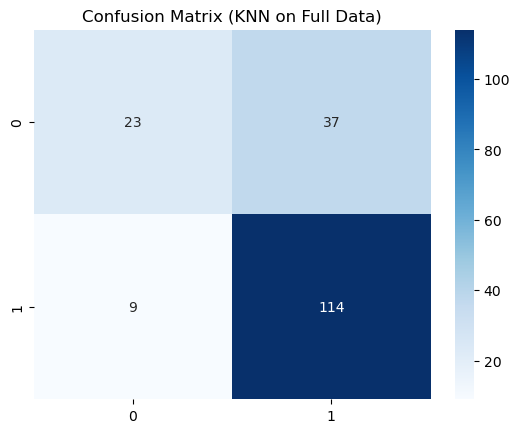

In [18]:
# -- Feature selection with SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X, y)

scores = pd.DataFrame({
    "Feature": X.columns,
    "F-Score": selector.scores_
}).sort_values(by="F-Score", ascending=False)

print(scores)

# Percentage distribution of target
counts = y.value_counts(normalize=True)
print("Target distribution:\n", counts)

# -- Confusion Matrix
model = KNeighborsClassifier()
model.fit(X, y)

cmat = confusion_matrix(y, model.predict(X))
sns.heatmap(cmat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (KNN on Full Data)")
plt.show()

# What I found

* What’s interesting about this confusion matrix is how well the model picks up on who actually survived. Out of all the survivors, it only got 9 wrong — meaning it’s really good at spotting people who lived. On the flip side, it struggles more with those who didn’t make it, often predicting survival when it shouldn’t. In other words, our KNN model seems “optimistic”: it leans toward guessing survival, and while that means very few survivors are missed, it does come at the cost of mistakenly labeling many non-survivors as survivors.

* By dropping every row with a missing value, we cut the dataset from 891 passengers down to just 183. That means we threw away almost 80% of the data! The main reason is the Cabin column — most passengers didn’t have cabin numbers recorded, so when we dropped those, the majority of rows disappeared. Instead of wiping out so much data, it’s usually better to drop just the Cabin column and fill in missing Age or Embarked values. That way, we keep almost all the passengers and give the model more to learn from.